In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
import re
import json
from tqdm.notebook import tqdm, trange
from tqdm import tqdm
from scipy import stats
import scipy.stats as st
from math import ceil
from collections import Counter

from pymongo import InsertOne, DeleteMany, ReplaceOne, UpdateOne

import query_builder
import grocery_base

In [2]:
font_size =12

SMALL_SIZE = font_size
MEDIUM_SIZE = font_size
BIGGER_SIZE = font_size

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

matplotlib.rcParams['font.serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "serif"
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})
# sns.set_style("white")
# sns.set_style("ticks")
sns.set(style="ticks", font="Times New Roman", font_scale=1.5)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

pd.set_option('display.max_colwidth', 200) # so long string like whoolefoods originalID will fit!

## Load Datasets

In [3]:
gdb_df=pd.read_csv('GroceryDB_foods.csv')
print(len(gdb_df))

50468


In [4]:
# Open and load the JSON file
with open('UpdatedProductIngredients_11_15.json', 'r') as file:
    ing_list=json.load(file)

In [5]:
# Function to flatten json
def flatten_ingredients(product_name,original_id,ingredients,parent_order=0,depth=1):
    rows=[]

    for ingredient in ingredients:
        # Calculate distance to first node
        distance_to_root=ingredient.get('order',0)+parent_order

        # Extract ingredient information, calculated distance, depth, and parent_order
        row = {
            'product_name': product_name,
            'original_ID': original_id,
            'ingredient_name': ingredient.get('ingredient_name'),
            'original_text': ingredient.get('original_text'),
            'general_name': ingredient.get('general_name'),
            'ingredient_type': ingredient.get('ingredient_type'),
            'order': ingredient.get('order'),
            'descriptors': ingredient.get('descriptors', []),
            'parent_order': parent_order,
            'distance_to_root': distance_to_root,
            'depth': depth
        }
        rows.append(row)

        # Rerun function for sub-ingredients
        if ingredient.get('sub_ingredients'):
            rows.extend(flatten_ingredients(product_name,original_id,
                ingredient['sub_ingredients'],parent_order=distance_to_root,depth=depth+1
            ))

    return rows

In [6]:
#Convert json into Dataframe
all_rows=[]
for product in ing_list:
    product_name=product.get('product_name')
    original_id=product.get('original_ID') 
    if product_name and product.get('ingredient_tree'):  
        all_rows.extend(flatten_ingredients(product_name,original_id,product['ingredient_tree']))

p_ingred=pd.DataFrame(all_rows)
len(p_ingred)

610765

In [7]:
#Calculate the width and depth of each product ingredient tree
p_ingred['tree_width']=None
p_ingred['sum_tree_depth']=None
p_ingred['ingred_count']=None

prods=p_ingred['original_ID'].unique()

for prod_id in tqdm(prods):
    S=p_ingred[p_ingred['original_ID']==prod_id]
    tree_width=S[S['parent_order']==0]['order'].max()
    sum_tree_depth=len(S[['parent_order','depth']].drop_duplicates())
    p_ingred.loc[S.index,'tree_width']=tree_width
    p_ingred.loc[S.index,'ingred_count']=len(S)
    p_ingred.loc[S.index,'sum_tree_depth']=sum_tree_depth
    #if len(S)<=1:
    #    p_ingred.loc[S.index,'sum_tree_depth']=0
    #else:
    #    p_ingred.loc[S.index,'sum_tree_depth']=sum_tree_depth

100%|██████████| 42540/42540 [14:07<00:00, 50.17it/s]


In [8]:
# Combine information from gdb_df into p_ingred
merged_df = p_ingred.merge(
    gdb_df[['original_ID','store','harmonized single category','f_FPro']],
    on='original_ID', how='left')
p_ingred['store'] = merged_df['store']
p_ingred['harmonized single category'] = merged_df['harmonized single category']
p_ingred['f_FPro'] = merged_df['f_FPro']

In [9]:
len(p_ingred['original_text'].unique())

19602

In [10]:
len(p_ingred['general_name'].unique())

14363

### Cochran's formula functions

In [11]:
#Cochran's formula for determining sample size
def get_sample_size(N, cl, e, p):
    
    # Get z-score
    z = st.norm.ppf(1 - (1 - cl) / 2)
    # Get n_0 value
    n_0 = z**2 * p * (1 - p) / e**2
    # Calculate n
    n = n_0 / (1 + (n_0 - 1) / N)
    # Round up to the nearest integer
    n = ceil(n)
    return n

#https://towardsdatascience.com/how-to-sample-data-with-code-327359dce10b

In [13]:
def generate_true_count_sample_csv(column_name, pop_df, filename_out, count_df, sample_size):

    count_adds = count_df.copy()

    count_adds = pop_df[
        pop_df[column_name].isin(count_adds[column_name])]\
    [[column_name, 'ingredient_type']].drop_duplicates()
    
    #Create binary column, 1 = ingredient and 0 = additive
    count_adds['true_ingredient']=0
    S=count_adds[count_adds['ingredient_type']=='ingredient'] 
    count_adds.loc[S.index, 'true_ingredient']=1
    
    count_adds = pd.merge(count_adds, count_df, on=column_name)
        
    count_adds.sample(sample_size).to_csv(filename_out)
    
    print("generated file 'ingredients_with_desc_sample.csv' with a sample size of: ",sample_size)
    
    return

In [14]:
def generate_true_count_stats(filename, column_name, count_df):

    annotated_df = pd.read_csv(filename)

    percent_add = ((annotated_df['ingredient_type']=='additive')&\
                   (annotated_df['true_ingredient']==0)).sum()/len(annotated_df)
    
    estimated_num_add = round(percent_add*len(count_df))

    percent_good = annotated_df['true_ingredient'].sum()/len(annotated_df)
    estimated_num_ig = round(percent_good*len(count_df))
    error = (len(count_df)*0.05)
    
    print('for ' + column_name+":")
    print()
    print("percent good additives:", percent_add)
    print("estimated total unique additives:", estimated_num_add)
    print(error)
    print()
    print("percent good ingreds:", percent_good)
    print("estimated total unique ingredients:", estimated_num_ig)
    print(error)
    
    return percent_good, percent_add

In [15]:
def calculate_confidence_interval(estimated_proportion, sample_size, confidence_level, count_df_size):
    z = st.norm.ppf(1 - (1-confidence_level)/2)
    lower_bound = estimated_proportion - z*np.sqrt((estimated_proportion*(1-estimated_proportion))/sample_size)
    upper_bound = estimated_proportion + z*np.sqrt((estimated_proportion*(1-estimated_proportion))/sample_size)
    return lower_bound*count_df_size, upper_bound*count_df_size

# Rules for Ingredients (including additives)

1. Ingredient definition: a component of a food. Products like "tacos", sub recipes like "filling" and blends of ingredients are not counted as ingredients.
2. Only 1 ingredient in a group with the same general_name will be randomly chosen to be the "true ingredient" 
3. two ingredients have been placed under the same "general_name" if one is a plural of the other, or one or both have a descriptor which is not directly relevant to the contents of the ingredient. ex. walmart beans will have  beans as a general name but kidney beans will be assumed different to pinto beans. 
4. if there are typos or extra information which does not refer to the type of ingredient they are not counted as ingredients. We want to see how many typos we have in the data dist and they are likely represented properly elsewhere.
5. accuracy is subject to the annotaters knowledge of spellings and ingredients, google searches were used in most cases, but not all.


# Identifying Additives
1. matched using additive dictionary
2. powders, flavors, and extracts are assumed additives for this analysis
3. common household spices not considered additives (basil, for example)

# Counting Unique Descriptors
1. descriptors should be a process, extra information resulting from a process (like puree, for example), and or a label providing information about growing or collection (organic)
2. descriptors which are synonyms of the related ingredient are not counted (vitamin b \<niacin\>)
3. descriptors which are synonyms are only counted once
4. only descriptors on a string marked "true ingredient" are counted

# All strings with descriptors

In [16]:
#Find the number of ingredients in dataset
column_name = 'ingredient_name'
count_df = p_ingred[column_name].value_counts()
count_df = pd.DataFrame(count_df).reset_index()
count_df.columns = [column_name, 'count']
print('total number of ingredients:',len(count_df))

#Cochran's formula for determining sample size
pop_size = len(count_df)
confidence = 0.95  # desired confidence
error = 0.05 # desired margin of error
p = 0.5 # target proportion, 0.5 is most conservative

Cochran_sample_size = get_sample_size(pop_size, confidence, error, p)

#randomly sample dataset to Cochran_sample_size
sample_size = generate_true_count_sample_csv(column_name,p_ingred,
    'ingredients_with_desc_sample.csv',count_df=count_df,sample_size=Cochran_sample_size)

total number of ingredients: 19602
generated file 'ingredients_with_desc_sample.csv' with a sample size of:  377


In [17]:
confidence = 0.95  # desired confidence
sample_size = Cochran_sample_size

estimated_prop, additive_prop = generate_true_count_stats('ingredients_with_desc_sample.csv',
                                                        'ingredient_name',count_df)

ing_lower_desc, ing_upper_desc = calculate_confidence_interval(estimated_prop,
                                                               sample_size,
                                                               confidence,
                                                               len(count_df))

add_lower_desc, add_upper_desc = calculate_confidence_interval(additive_prop,
                                                               sample_size,
                                                               confidence,
                                                               len(count_df))

print('ingredient counts:',ing_lower_desc, ing_upper_desc)
print('additive counts:', add_lower_desc, add_upper_desc)

for ingredient_name:

percent good additives: 0.07427055702917772
estimated total unique additives: 1456
980.1

percent good ingreds: 0.9257294429708223
estimated total unique ingredients: 18146
980.1
ingredient counts: 17627.31483812673 18664.982244101386
additive counts: 937.0177558986148 1974.6851618732683


# Strings occurring>1 with descriptors

In [18]:
column_name = 'ingredient_name'
count_df = p_ingred[column_name].value_counts()
count_df = pd.DataFrame(count_df).reset_index()
count_df.columns = [column_name, 'count']
count_df = count_df[count_df['count']>1]
print('total number of ingredients:',len(count_df))

pop_size = len(count_df)
confidence = 0.95  # desired confidence
error = 0.05 # desired margin of error
p = 0.5 # target proportion, 0.5 is most conservative

Cochran_sample_size = get_sample_size(pop_size, confidence, error, p)

#randomly sample dataset to Cochran_sample_size
sample_size = generate_true_count_sample_csv(column_name,p_ingred,
    'filtered_ingredients_with_desc_sample.csv',count_df=count_df,sample_size=Cochran_sample_size)

total number of ingredients: 10006
generated file 'ingredients_with_desc_sample.csv' with a sample size of:  370


In [19]:
confidence = 0.95  # desired confidence
sample_size = Cochran_sample_size

estimated_prop, additive_prop = generate_true_count_stats('filtered_ingredients_with_desc_sample.csv',
                                                        'ingredient_name with >1 descriptor',count_df)

ing_lower_desc_filt, ing_upper_desc_filt = calculate_confidence_interval(estimated_prop,
                                                                         sample_size,
                                                                         confidence,
                                                                         len(count_df))

add_lower_desc_filt, add_upper_desc_filt = calculate_confidence_interval(additive_prop,
                                                                         sample_size,
                                                                         confidence,
                                                                         len(count_df))

print('ingredient counts:',ing_lower_desc_filt, ing_upper_desc_filt)
print('additive counts:', add_lower_desc_filt, add_upper_desc_filt)

for ingredient_name with >1 descriptor:

percent good additives: 0.11081081081081082
estimated total unique additives: 1109
500.3

percent good ingreds: 0.8891891891891892
estimated total unique ingredients: 8897
500.3
ingredient counts: 8577.193203040917 9217.260851013138
additive counts: 788.7391489868635 1428.8067969590825


# All unfiltered strings without descriptors

In [20]:
column_name = 'general_name'
count_df = p_ingred[column_name].value_counts()
count_df = pd.DataFrame(count_df).reset_index()
count_df.columns = [column_name, 'count']
print('total number of ingredients:',len(count_df))

pop_size = len(count_df)
confidence = 0.95  # desired confidence
error = 0.05 # desired margin of error
p = 0.5 # target proportion, 0.5 is most conservative

Cochran_sample_size = get_sample_size(pop_size, confidence, error, p)

#randomly sample dataset to Cochran_sample_size
sample_size = generate_true_count_sample_csv(column_name,p_ingred,
    'general_names_sample.csv',count_df=count_df,sample_size=Cochran_sample_size)

total number of ingredients: 14363
generated file 'ingredients_with_desc_sample.csv' with a sample size of:  375


In [21]:
confidence = 0.95  # desired confidence
sample_size = Cochran_sample_size

estimated_prop, additive_prop = generate_true_count_stats('general_names_sample.csv',
                                                       'general name',count_df)

ing_lower, ing_upper = calculate_confidence_interval(estimated_prop,
                                                                    sample_size,
                                                                    confidence,
                                                                    len(count_df))

add_lower, add_upper = calculate_confidence_interval(additive_prop,
                                                                    sample_size,
                                                                    confidence,
                                                                    len(count_df))

print('ingredient counts:',ing_lower, ing_upper)
print('additive counts:', add_lower, add_upper)

for general name:

percent good additives: 0.058666666666666666
estimated total unique additives: 843
718.1500000000001

percent good ingreds: 0.9413333333333334
estimated total unique ingredients: 13520
718.1500000000001
ingredient counts: 13178.749286433322 13861.992046900014
additive counts: 501.00795309998784 1184.2507135666788


We expect this number to be less in reality as only synonyms which were within the sample were removed from the count. synonyms across the entire corpus are likely much more prevelant than what we calculated, and thus this is an approximate upper bound. 

# All strings which occur more than once without descriptors

In [22]:
column_name = 'general_name'
count_df = p_ingred[column_name].value_counts()
count_df = pd.DataFrame(count_df).reset_index()
count_df.columns = [column_name, 'count']
count_df = count_df[count_df['count']>1]
print('total number of ingredients:',len(count_df))

pop_size = len(count_df)
confidence = 0.95  # desired confidence
error = 0.05 # desired margin of error
p = 0.5 # target proportion, 0.5 is most conservative

Cochran_sample_size = get_sample_size(pop_size, confidence, error, p)

#randomly sample dataset to Cochran_sample_size
sample_size = generate_true_count_sample_csv(column_name,p_ingred,
    'general_name_morethan1_sample.csv',count_df=count_df,sample_size=Cochran_sample_size)

total number of ingredients: 7407
generated file 'ingredients_with_desc_sample.csv' with a sample size of:  366


In [23]:
confidence = 0.95  # desired confidence
sample_size = Cochran_sample_size

estimated_prop, additive_prop = generate_true_count_stats('general_name_morethan1_sample.csv',
                                                        'cleaned name',count_df)

ing_lower_filt, ing_upper_filt = calculate_confidence_interval(estimated_prop,
                                                                         sample_size,
                                                                         confidence,
                                                                         len(count_df))

add_lower_filt, add_upper_filt = calculate_confidence_interval(additive_prop,
                                                                         sample_size,
                                                                         confidence,
                                                                         len(count_df))

print('ingredient counts:',ing_lower_filt, ing_upper_filt)
print('additive counts:', add_lower_filt, add_upper_filt)

for cleaned name:

percent good additives: 0.08743169398907104
estimated total unique additives: 648
370.35

percent good ingreds: 0.912568306010929
estimated total unique ingredients: 6759
370.35
ingredient counts: 6545.046629856345 6973.740255389557
additive counts: 433.25974461044336 861.953370143655


We expect these numbers to be larger in reality given that not all of the single occurence items are issues.

We expect this number to be less in reality as only synonyms which were within the sample were removed from the count. synonyms across the entire corpus are likely much more prevelant than what we calculated, and thus this is an approximate upper bound. 

# Count Descriptors

In [24]:
from collections import Counter

# count all DESCRIPTORS in two ways
desc_count_ALL = Counter()
for x in tqdm(p_ingred['descriptors']):
    for y in x:
        desc_count_ALL[y]+=1
        
        
# convert to df for easy export       
desc_count_all_df = pd.DataFrame.from_dict(desc_count_ALL, orient='index').reset_index()
desc_count_all_df.columns = ['descriptor','count']
desc_count_all_df.sort_values('count',inplace=True,ascending=False)
desc_count_all_df.reset_index().drop(labels=['index'],axis='columns')

100%|██████████| 610765/610765 [00:00<00:00, 3784022.56it/s]


,descriptor,count
0,modified,5311
1,whole,5115
2,pasteurized,4719
3,enriched,4339
4,dried,4240
...,...,...
1768,groundwhite,1
1769,dextrose-vegetable,1
1770,cloud,1
1771,dehydra-ted,1


In [25]:
desc_count_all_df_filt = desc_count_all_df[desc_count_all_df['count']>10]

In [26]:
len(desc_count_all_df_filt)

373

# Preparing plots

In [27]:
# with descriptors
ing_desc_error = (ing_upper_desc-ing_lower_desc)/2
ing_desc = ing_lower_desc + ing_desc_error

# with descriptors, additives
add_desc_error = (add_upper_desc-add_lower_desc)/2
add_desc = add_lower_desc + add_desc_error

# with descriptors, filtered
ing_desc_filt_error = (ing_upper_desc_filt-ing_lower_desc_filt)/2
ing_desc_filt = ing_lower_desc_filt + ing_desc_filt_error

# with descriptors, filtered, additives
ing_filt_error = (ing_upper_filt-ing_lower_filt)/2
ing_filt = ing_lower_filt + ing_filt_error

# without descriptors
ing_error = (ing_upper-ing_lower)/2
ing = ing_lower + ing_error

# without descriptors, additives
add_error = (add_upper-add_lower)/2
add = add_lower + add_error

# without descriptors, filtered
ing_filt_error = (ing_upper_filt-ing_lower_filt)/2
ing_filt = ing_lower_filt + ing_filt_error

# without descriptors, filtered, additives
add_filt_error = (add_upper_filt-add_lower_filt)/2
add_filt = add_lower_filt + add_filt_error

In [28]:
y=['ingredients (including adds) with descriptors',
                    'additives with descriptors',
                    'filtered ingredients (including adds) with descriptors',
                    'filtered additives with descriptors',
                    'ingredients (including adds) without descriptors',
                    'additives without descriptors',
                    'filtered ingredients (including adds) without descriptors',
                    'filtered additives without descriptors']

In [29]:
x=[ing_desc,
    add_desc,
    ing_desc_filt, 
    ing_filt,
    ing,
    add,
    ing_filt,
    add_filt
]

In [30]:
error_series=[
    ing_desc_error,
    add_desc_error,
    ing_desc_filt_error,
    ing_filt_error,
    ing_error,
    add_error,
    ing_filt_error,
    add_filt_error
]

In [31]:
plot_df = pd.DataFrame(y,x).reset_index()
plot_df.columns = ['counts', 'type']
plot_df['counts'] = plot_df['counts'].apply(round)
plot_df['error'] = error_series
plot_df['error'] = plot_df['error']

In [32]:
no_filter = plot_df[~plot_df['type'].str.contains('filtered')]

In [33]:
no_filter

,counts,type,error
0,18146,ingredients (including adds) with descriptors,518.833703
1,1456,additives with descriptors,518.833703
4,13520,ingredients (including adds) without descriptors,341.621380
5,843,additives without descriptors,341.621380


In [34]:
no_filter_fixed_labels = no_filter.copy()
no_filter_fixed_labels['type'] = no_filter['type']\
.str.replace('ingredients \(including adds\)',repl='')\
.str.replace('additives',repl='')\
.str.replace('without descriptors', repl='without incorporating\ndescriptors')\
.str.replace('with descriptors', repl='incorporating\ndescriptors')\
.str.strip()

In [35]:
no_filter_fixed_labels = no_filter_fixed_labels.reset_index()

In [36]:
ing_df = no_filter_fixed_labels.iloc[[0,2]]
add_df = no_filter_fixed_labels.iloc[[1,3]]

In [37]:
# from this paper https://www.sciencedirect.com/science/article/pii/S0889157521001204
ingID = [[8,6500,'Ahuja et al.',0]]
#ing_df = ing_df.append(pd.DataFrame(ingID,columns=ing_df.columns), ignore_index=False)
ing_df = pd.concat([ing_df, pd.DataFrame(ingID, columns=ing_df.columns)], ignore_index=False)
ing_df=ing_df.reset_index()
ing_df = ing_df.drop(['index','level_0'],axis=1)

### Figure S12 part 1-2

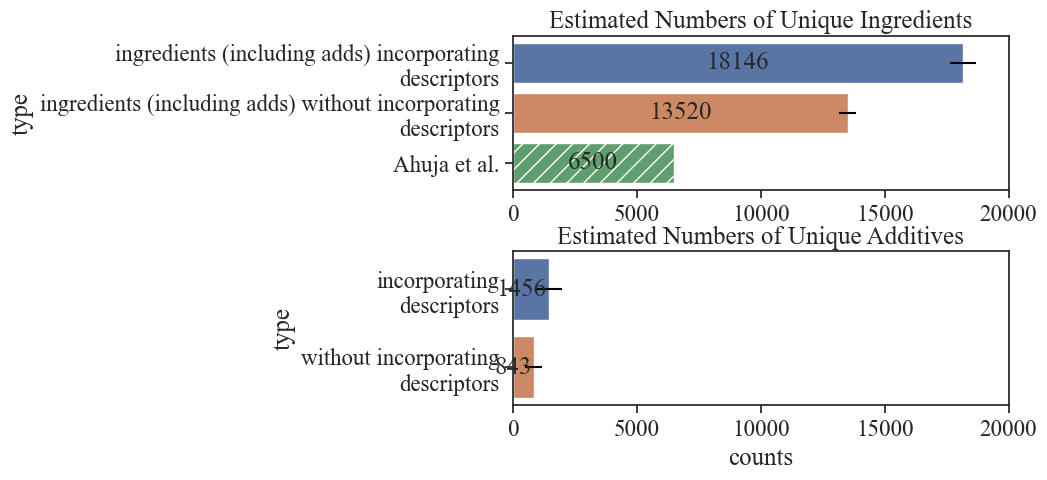

In [38]:
fig, axs = plt.subplots(2)

bar1 = sns.barplot(ax=axs[0],x=ing_df['counts'],
            y=ing_df['type'])

axs[0].errorbar(y=ing_df['type'],
            x=ing_df['counts'],
             xerr=ing_df['error'],
             ls='',
             color='black')

# Define some hatches
hatches = ['', '', '//']

# Loop over the bars
for i,thisbar in enumerate(bar1.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

axs[0].set_xlabel(xlabel='')
axs[0].set_xlim([0,20000])

axs[0].set_title("Estimated Numbers of Unique Ingredients")

sns.barplot(ax=axs[1],x=add_df['counts'],
            y=add_df['type'])

axs[1].errorbar(y=add_df['type'],
            x=add_df['counts'],
             xerr=add_df['error'],
             ls='',
             color='black')

axs[1].set_xlim([0,20000])

axs[1].set_title("Estimated Numbers of Unique Additives")


axs[0].bar_label(axs[0].containers[0], label_type='center')
axs[1].bar_label(axs[1].containers[0], label_type='center', padding=-7)

plt.subplots_adjust(hspace=0.4)

#plt.savefig('estimated_numbers_unique_ingredients_additives_horizontal.png')

In [39]:
ing_df = ing_df[~ing_df['type'].str.contains('Ahuja')]

[Text(0, 0, '18146'), Text(0, 0, '13520')]

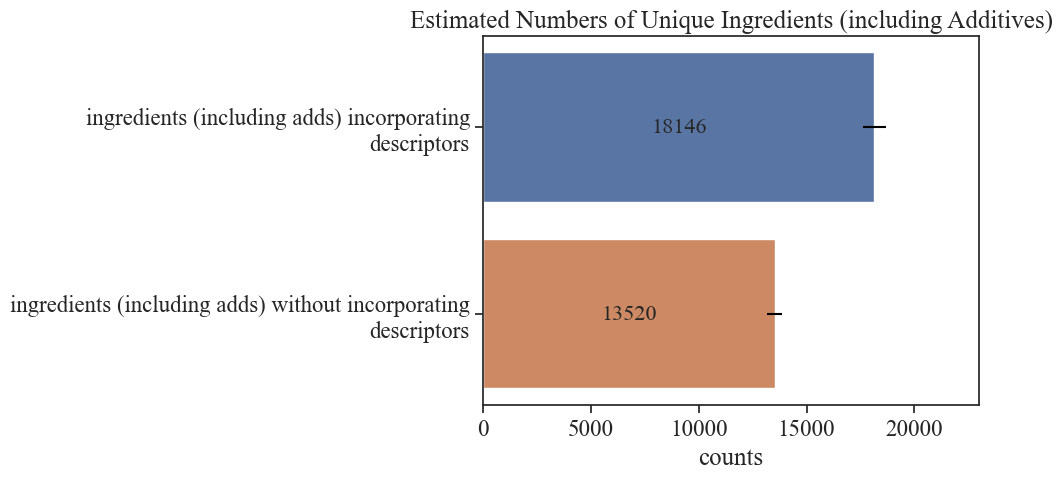

In [40]:
fig, ax = plt.subplots()

bar1 = sns.barplot(ax=ax,x=ing_df['counts'],
            y=ing_df['type'])

ax.errorbar(y=ing_df['type'],
            x=ing_df['counts'],
             xerr=ing_df['error'],
             ls='',
             color='black')

ax.set_xlim([0,23000])

# Define some hatches
hatches = ['', '', '//']

# Loop over the bars
for i,thisbar in enumerate(bar1.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

ax.set_ylabel(ylabel='')

#ax.set_xlim([0,20000])

ax.set_title("Estimated Numbers of Unique Ingredients (including Additives)")


ax.bar_label(ax.containers[0], label_type='center', fontsize=16)

[Text(-10, 0, '1456'), Text(-10, 0, '843')]

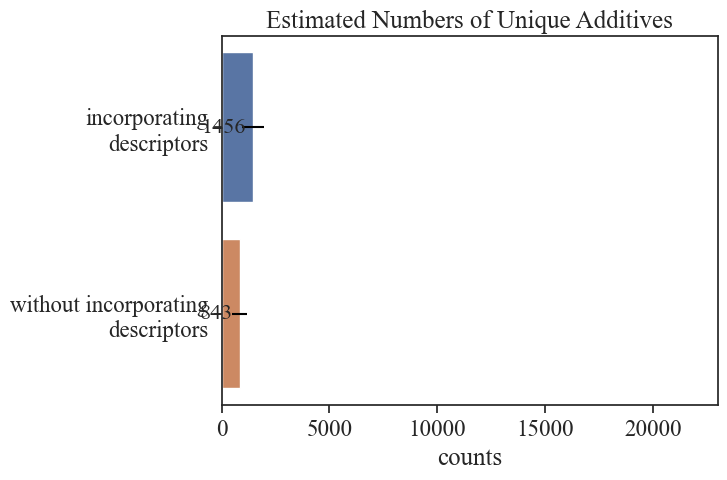

In [41]:
fig, ax = plt.subplots()

bar1 = sns.barplot(ax=ax,x=add_df['counts'],
            y=add_df['type'])

ax.errorbar(y=add_df['type'],
            x=add_df['counts'],
             xerr=add_df['error'],
             ls='',
             color='black')

ax.set_xlim([0,23000])

# Define some hatches
hatches = ['', '', '//']

# Loop over the bars
for i,thisbar in enumerate(bar1.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

ax.set_ylabel(ylabel='')

ax.set_title("Estimated Numbers of Unique Additives")


ax.bar_label(ax.containers[0], label_type='center', padding=-10, fontsize=16)

### Figure S12 part 4 

In [42]:
ingID = [[8,6500,'Ahuja et al.',0]]

[Text(-10, 0, '6500')]

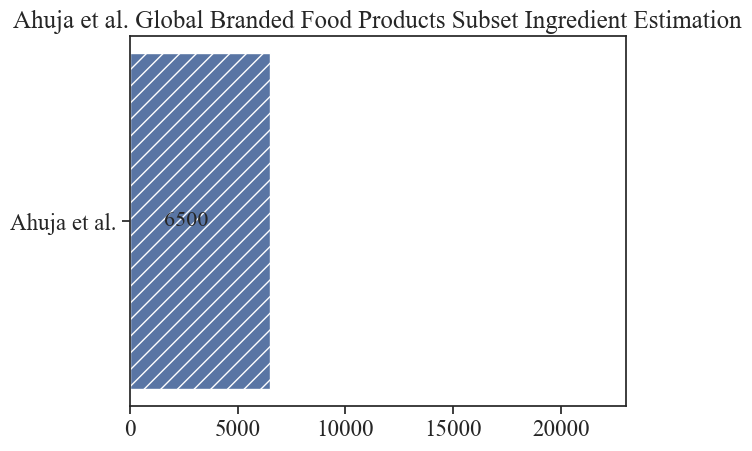

In [43]:
fig, ax = plt.subplots()

bar1 = sns.barplot(ax=ax,x=[6500],
            y=['Ahuja et al.'])

ax.errorbar(y=['Ahuja et al.'],
            x=[6500],
             xerr=[0],
             ls='',
             color='black')

ax.set_xlim([0,23000])

# Define some hatches
hatches = ['//']

# Loop over the bars
for i,thisbar in enumerate(bar1.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])


ax.set_ylabel(ylabel='')

ax.set_title('Ahuja et al. Global Branded Food Products Subset Ingredient Estimation')


ax.bar_label(ax.containers[0], label_type='center', padding=-10, fontsize=16)

# Final Multiplot (Figure S12)

C:\Users\sobek\AppData\Local\Temp\ipykernel_29732\2589326651.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=['0','5000','10000','15000','20000'],fontsize=14)
C:\Users\sobek\AppData\Local\Temp\ipykernel_29732\2589326651.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=['0','5000','10000','15000','20000'],fontsize=14)
C:\Users\sobek\AppData\Local\Temp\ipykernel_29732\2589326651.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(labels=['0','5000','10000','15000','20000'],fontsize=14)
C:\Users\sobek\AppData\Local\Temp\ipykernel_29732\2589326651.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(labels=['0','5000','10000','15000','20000'], fontsize=14)


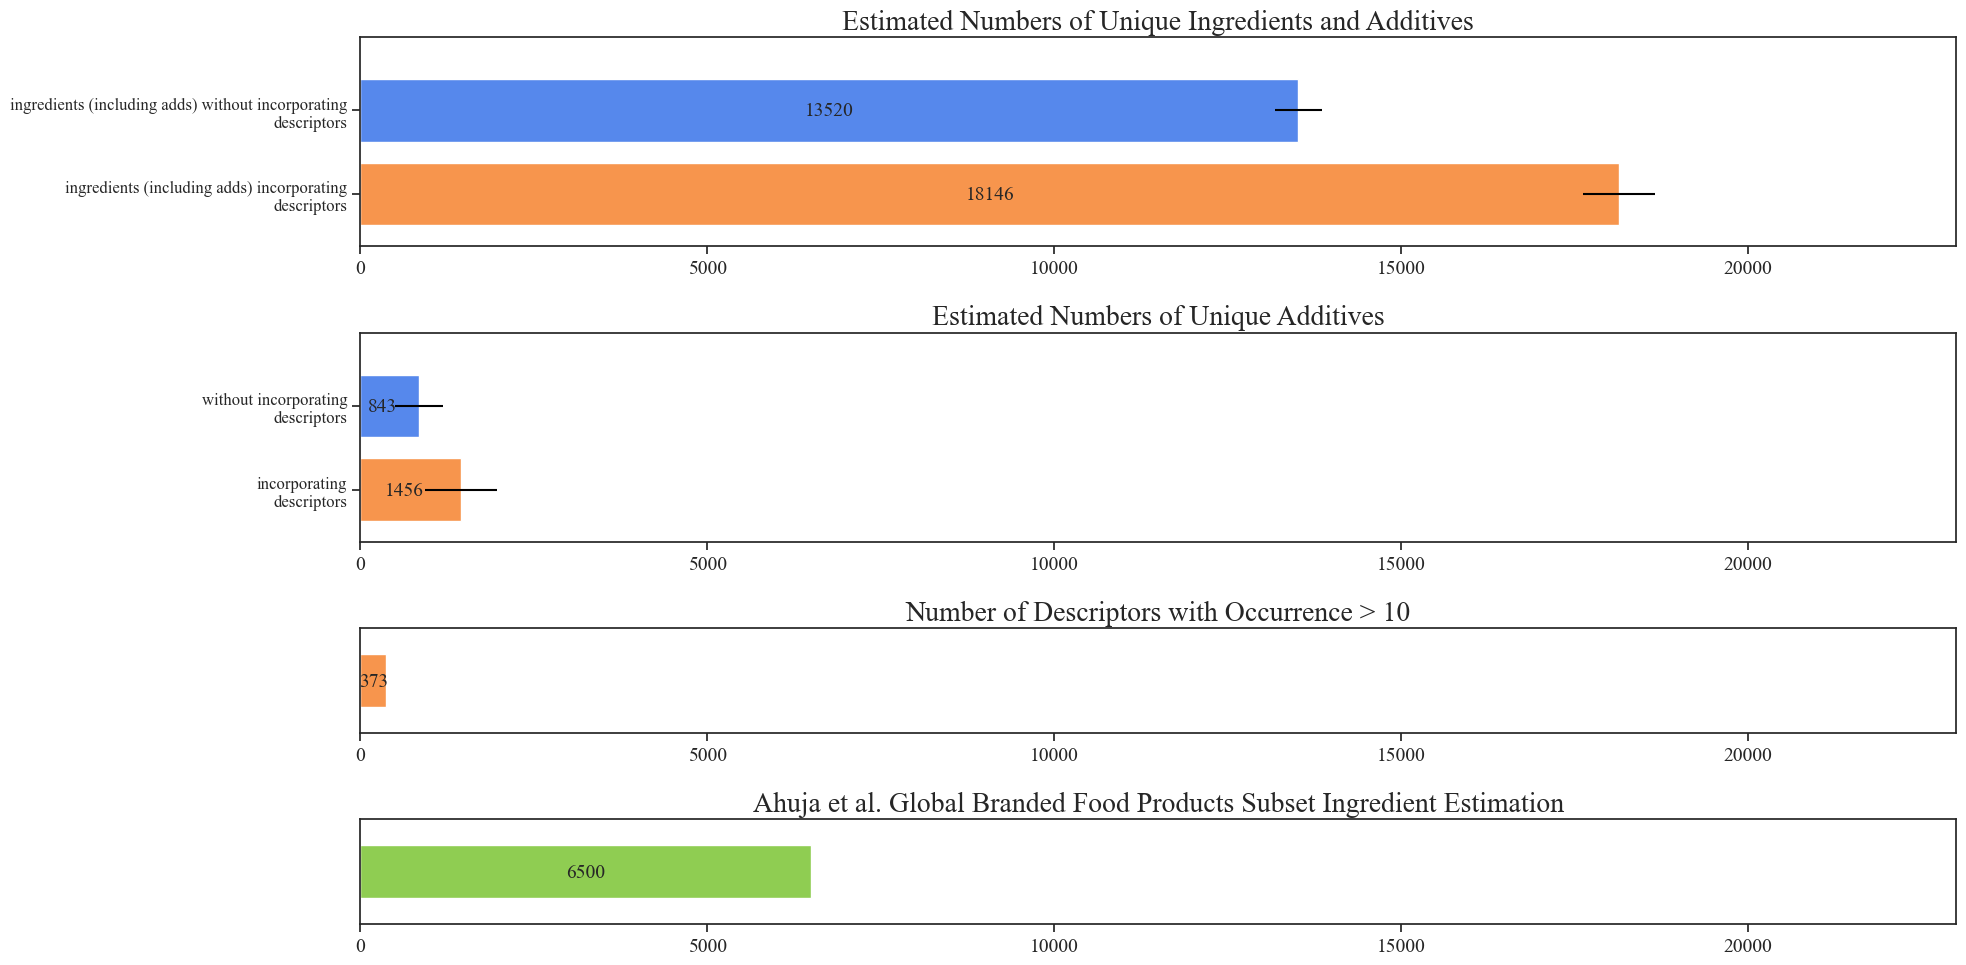

In [44]:
fig, ax = plt.subplots(4,1,gridspec_kw={'height_ratios': [2, 2, 1, 1]},figsize=(20, 10))

plt.subplots_adjust(hspace=1)
                    #left=0.1,
                    #bottom=0.1, 
                    #right=0.9, 
                    #top=0.9, 
                    #wspace=0.4, 
                    #hspace=0.4)

#BAR 1
y_pos = [2.5,6.5]
bar1 = ax[0].barh(y=y_pos, width=ing_df['counts'], height=3,
                  align='center', color=['#F7954D', '#5688EC'])
ax[0].set_yticks(y_pos)   
ax[0].set_yticklabels(ing_df['type'], fontsize=12)
ax[0].set_xticklabels(labels=['0','5000','10000','15000','20000'],fontsize=14)

ax[0].errorbar(y=[2.5,6.5],
            x=ing_df['counts'],
             xerr=ing_df['error'],
             ls='',
             color='black')

ax[0].set_xlim([0,23000])
ax[0].set_ylim([0,10])
ax[0].set_ylabel(ylabel='')
ax[0].set_title("Estimated Numbers of Unique Ingredients and Additives", fontsize=20)
ax[0].bar_label(ax[0].containers[0], label_type='center', fontsize=14)


#BAR 2
y_pos = [2.5,6.5]
bar2 = ax[1].barh(y=y_pos, width=add_df['counts'], height=3,
                  align='center', color=['#F7954D', '#5688EC'])
ax[1].set_yticks(y_pos)   
ax[1].set_yticklabels(add_df['type'], fontsize=12)
ax[1].set_xticklabels(labels=['0','5000','10000','15000','20000'],fontsize=14)

ax[1].errorbar(y=y_pos,
            x=add_df['counts'],
             xerr=add_df['error'],
             ls='',
             color='black')

ax[1].set_xlim([0,23000])
ax[1].set_ylim([0,10])
ax[1].set_ylabel(ylabel='')
ax[1].set_title("Estimated Numbers of Unique Additives", fontsize=20)
ax[1].bar_label(ax[1].containers[0], label_type='center', padding=-5, fontsize=14)


#BAR 3
bar3 = ax[2].barh(y=[5], width=len(desc_count_all_df_filt),
                  height=5, align='center',color='#F7954D')
ax[2].get_yaxis().set_ticks([])
ax[2].set_xticklabels(labels=['0','5000','10000','15000','20000'],fontsize=14)

ax[2].set_xlim([0,23000])
ax[2].set_ylim([0,10])
ax[2].set_ylabel(ylabel='')
ax[2].set_title("Number of Descriptors with Occurrence > 10", fontsize=20)
ax[2].bar_label(ax[2].containers[0], label_type='center',padding=0, fontsize=14)


#BAR 4
bar4 = ax[3].barh(y=[5], width=6500, height=5, align='center', color="#8FCD52")
ax[3].set_xticklabels(labels=['0','5000','10000','15000','20000'], fontsize=14)
ax[3].get_yaxis().set_ticks([])
ax[3].set_xlim([0,23000])
ax[3].set_ylim([0,10])
ax[3].set_ylabel(ylabel='')
ax[3].set_title('Ahuja et al. Global Branded Food Products Subset Ingredient Estimation', fontsize=20)
ax[3].bar_label(ax[3].containers[0], label_type='center', fontsize=14)

# Display the figure with all subplots
plt.tight_layout()
plt.savefig("figure_S12.pdf", format="pdf", bbox_inches="tight")
plt.show()
